In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

time: 1.16 s (started: 2022-10-05 18:37:11 +08:00)


In [2]:
x = pickle.load(open('./data/fundamentals2.pkl', 'rb'))
y = pickle.load(open('./data/performance2.pkl', 'rb'))

time: 16 ms (started: 2022-10-05 18:37:13 +08:00)


In [3]:
print(x.shape)
print(y.shape)

(34502, 74)
(34502, 7)
time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [4]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34502 entries, 0 to 34501
Data columns (total 74 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Ticker                                           34502 non-null  object        
 1   Report Date                                      34502 non-null  datetime64[ns]
 2   SimFinId                                         34502 non-null  int64         
 3   Currency                                         34502 non-null  object        
 4   Fiscal Year                                      34502 non-null  int64         
 5   Fiscal Period_x                                  34502 non-null  object        
 6   Publish Date                                     34502 non-null  datetime64[ns]
 7   Restated Date_x                                  34502 non-null  datetime64[ns]
 8   Shares (Basic)_x                    

As there are still some null values, we would need to fix these as any feature engineered ratio could give us an error. Let's fill these null values with zero first.

In [5]:
x = x.fillna(0)

time: 594 ms (started: 2022-10-05 18:37:13 +08:00)


In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34502 entries, 0 to 34501
Data columns (total 74 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Ticker                                           34502 non-null  object        
 1   Report Date                                      34502 non-null  datetime64[ns]
 2   SimFinId                                         34502 non-null  int64         
 3   Currency                                         34502 non-null  object        
 4   Fiscal Year                                      34502 non-null  int64         
 5   Fiscal Period_x                                  34502 non-null  object        
 6   Publish Date                                     34502 non-null  datetime64[ns]
 7   Restated Date_x                                  34502 non-null  datetime64[ns]
 8   Shares (Basic)_x                    

In [7]:
# Add in two new columns
# Market Cap = Shares (Diluted)_x  x Open Price
# EV = Market cap + LT debt + ST debt - Cash
# EBIT = Net Income - Interest Expense - Income Tax (Expense) Benefit, Net

x['Market Cap'] = x['Shares (Diluted)_x'] * y['Open1']
x['EV'] = x['Market Cap'] + x['Long Term Debt'] + x['Short Term Debt'] - x['Cash, Cash Equivalents & Short Term Investments']
x['EBIT'] = x['Net Income'] - x['Interest Expense, Net'] - x['Income Tax (Expense) Benefit, Net']

time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [8]:
x.head()

,Ticker,Report Date,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap,EV,EBIT
0,A,2016-10-31,45846,USD,2016,Q4,2016-12-20,2018-12-20,324000000.0,328000000.0,...,-26000000.0,-78000000.0,-38000000.0,27000000.0,-43000000.0,-56000000.0,90000000,1.421224e+10,1.382724e+10,167000000.0
1,A,2017-01-31,45846,USD,2017,Q1,2017-03-08,2018-03-06,322000000.0,326000000.0,...,-69000000.0,-101000000.0,-42000000.0,89000000.0,-93000000.0,-58000000.0,-48000000,1.566104e+10,1.541204e+10,209000000.0
2,A,2017-04-30,45846,USD,2017,Q2,2017-06-06,2018-05-31,321000000.0,325000000.0,...,0.0,-43000000.0,-43000000.0,52000000.0,-75000000.0,-67000000.0,148000000,1.803750e+10,1.769150e+10,206000000.0
3,A,2017-07-31,45846,USD,2017,Q3,2017-09-06,2018-08-30,321000000.0,326000000.0,...,-57000000.0,-101000000.0,-42000000.0,39000000.0,32000000.0,29000000.0,174000000,1.966432e+10,1.918232e+10,206000000.0
4,A,2017-10-31,45846,USD,2017,Q4,2017-12-21,2018-12-20,324000000.0,327000000.0,...,0.0,-60000000.0,-43000000.0,-70000000.0,8000000.0,-106000000.0,115000000,2.215098e+10,2.148398e+10,239000000.0


time: 16 ms (started: 2022-10-05 18:37:13 +08:00)


In [9]:
# Create a function to feature engineer many different financial ratios
# Takes in original fundamental dataframe then output all the ratio

def getRatios(df):    
    # Create a new dataframe to copy ratios into
    df1 = pd.DataFrame()
    
    # EV/EBIT
    df1['EV_EBIT'] = df['EV']/df['EBIT']

    # Operating Income over (Net working capital + Fidfed assets)
    df1['OI_NWCFA'] = df['Operating Income (Loss)']/\
    (df['Total Current Assets'] - df['Total Current Liabilities'] + df['Property, Plant & Equipment, Net'])

    # Price to earnings
    df1['PE'] = df['Market Cap']/df['Net Income']

    # Price to book
    df1['PB'] = df['Market Cap']/df['Total Equity']

    # Price to sales
    df1['PS'] = df['Market Cap']/df['Revenue']

    # Operating Income over Interest Edfpense
    df1['OI_IntExp'] = df['Operating Income (Loss)']/ -df['Interest Expense, Net']

    # Working Capital Ratio (CA/CL)
    df1['WorkingCap'] = df['Total Current Assets']/ df['Total Current Liabilities']

    # Return on Equity
    df1['ROE'] = df['Net Income']/ df['Total Equity']

    # Return on Capital Employed
    df1['ROCE'] = df['EBIT']/ (df['Total Assets'] - df['Total Current Liabilities'])

    # Debt/Equity
    df1['DE'] = df['Total Liabilities']/ df['Total Equity']

    # Debt Ratio
    df1['DebtRatio'] = df['Total Assets']/ df['Total Liabilities']

    # Cash Ratio
    df1['CashRatio'] = df['Cash, Cash Equivalents & Short Term Investments']/ df['Total Current Liabilities']

    # Asset Turnover
    df1['AssetTurnover'] = df['Revenue']/ df['Property, Plant & Equipment, Net']

    # Gross Profit Margin
    df1['GPM'] = df['Gross Profit']/ df['Revenue']

    # Working Capital over total assets
    df1['WC_TA'] = (df['Total Current Assets'] - df['Total Current Liabilities'])/ df['Total Assets']

    # Retained earnings over total assets
    df1['RE_TA'] = df['Retained Earnings']/ df['Total Assets']

    # EBIT over total assets
    df1['EBIT_TA'] = df['EBIT']/ df['Total Assets']

    # Equity over liabilities
    df1['Equity_Liab'] = df['Total Equity']/ df['Total Liabilities']
    
    return df1

time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [10]:
def fixRatios(df):
    '''
    Takes in df, edits it to have the distributions clipped.
    The distribution clippings are done manually by eye,
    with human judgement based on the information.
    '''
    df["ROE"].clip(-5, 5, inplace=True)
    df["OI_NWCFA"].clip(-5, 5, inplace=True)
    df["EV_EBIT"].clip(-500, 500, inplace=True)
    df["PE"].clip(-1000, 1000, inplace=True)
    df["PB"].clip(-50, 100, inplace=True)    
    df["PS"].clip(0, 500, inplace=True)
    df["OI_IntExp"].clip(-600, 600, inplace=True)#-600, 600
    df["WorkingCap"].clip(0, 30, inplace=True)  
    df["ROCE"].clip(-2, 2, inplace=True)
    df["DE"].clip(0, 100, inplace=True)
    df["DebtRatio"].clip(0, 50, inplace=True)  
    df["CashRatio"].clip(0, 30, inplace=True)
    df["AssetTurnover"].clip(-2000, 2000, inplace=True)# 0, 500
    df["GPM"].clip(0, 1, inplace=True) #how can be >100%?
    df["WC_TA"].clip(-1.5, 2, inplace=True)
    df["RE_TA"].clip(-20, 2, inplace=True)
    df["EBIT_TA"].clip(-2, 1, inplace=True)
    df["Equity_Liab"].clip(-2, 20, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [11]:
X = getRatios(x)
fixRatios(X)

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34497,190.226788,0.162071,263.172831,29.454035,41.218524,600.000000,4.955648,0.111919,0.132893,0.363616,3.750153,2.809967,13.838362,0.789181,0.647814,0.552518,0.111129,2.750153
34498,401.544454,0.027134,455.367693,11.194813,30.310853,281.800000,7.889376,0.024584,0.024432,0.198130,6.047194,5.651679,11.991617,0.785479,0.773617,0.333149,0.021689,5.047194
34499,206.724364,0.041892,278.735919,8.760902,19.453274,459.400000,6.229416,0.031431,0.035773,0.269457,4.711162,3.871998,13.301299,0.778988,0.733024,0.324628,0.030759,3.711162
34500,-451.177169,-0.020088,-738.189122,9.281098,21.600759,-120.111111,6.530220,-0.012573,-0.017744,0.250797,4.987290,3.589801,10.494563,0.756041,0.733442,0.323538,-0.015391,3.987290


time: 31 ms (started: 2022-10-05 18:37:13 +08:00)


## Feature engineer y dataframe

In [12]:
y.tail()

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
34497,ZYXI,2020-06-30,20.95,1160230.0,2021-06-30,14.13,144577.0
34498,ZYXI,2020-09-30,15.55,1115434.0,2021-09-30,NaN,NaN
34499,ZYXI,2020-12-31,12.71,318435.0,2021-12-31,NaN,NaN
34500,ZYXI,2021-03-31,13.60,423240.0,2022-03-31,NaN,NaN
34501,ZYXI,2021-06-30,14.13,144577.0,2022-06-30,NaN,NaN


time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [13]:
# Create function to calculate the stock performance

def getReturns(df):
    '''
    Takes in df, which has the stock prices and respective dates
    Returns a DataFrame df1 containing the ticker and the 
    relative change in price onldf1 ("Returns").
    '''
    df1=pd.DataFrame()
    df1["Ticker"] = df["Ticker"]
    df1["Returns"] = np.where(df['Open2'].isnull(), None, (df["Open2"]-df["Open1"]) / df["Open1"])
    
    return df1
    
    
#     if df['Open2'].isnull():
#         df1["Returns"] = df['Open2'].isnull()
#     else:
#         df1["Returns"] = (df["Open2"]-df["Open1"]) / df["Open1"]
#     return df1

time: 0 ns (started: 2022-10-05 18:37:13 +08:00)


In [14]:
y = getReturns(y)
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34502 entries, 0 to 34501
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Ticker   34502 non-null  object
 1   Returns  26685 non-null  object
dtypes: object(2)
memory usage: 539.2+ KB
time: 15 ms (started: 2022-10-05 18:37:13 +08:00)


## REDO THIS VISUALISATION LATER

In [15]:
# # Make a plot of the distributions.
# cols, rows = 3, 5
# plt.figure(figsize=(5*cols, 5*rows))
# for i in range(1, cols*rows):
#     if i<len(x.keys()):
#         plt.subplot(rows, cols, i)
#         k=x.keys()[i]
#         x[k].hist(bins=100)
#         plt.title(k);

time: 0 ns (started: 2022-10-05 18:37:14 +08:00)


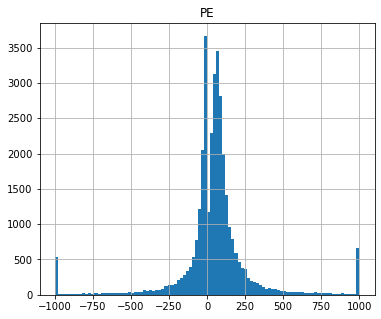

time: 187 ms (started: 2022-10-05 18:37:14 +08:00)


In [16]:
# See one of the distributions
k=X.keys()[2] # Try different numbers, 0-14.
X[k].hist(bins=100, figsize=(6,5))
plt.title(k);

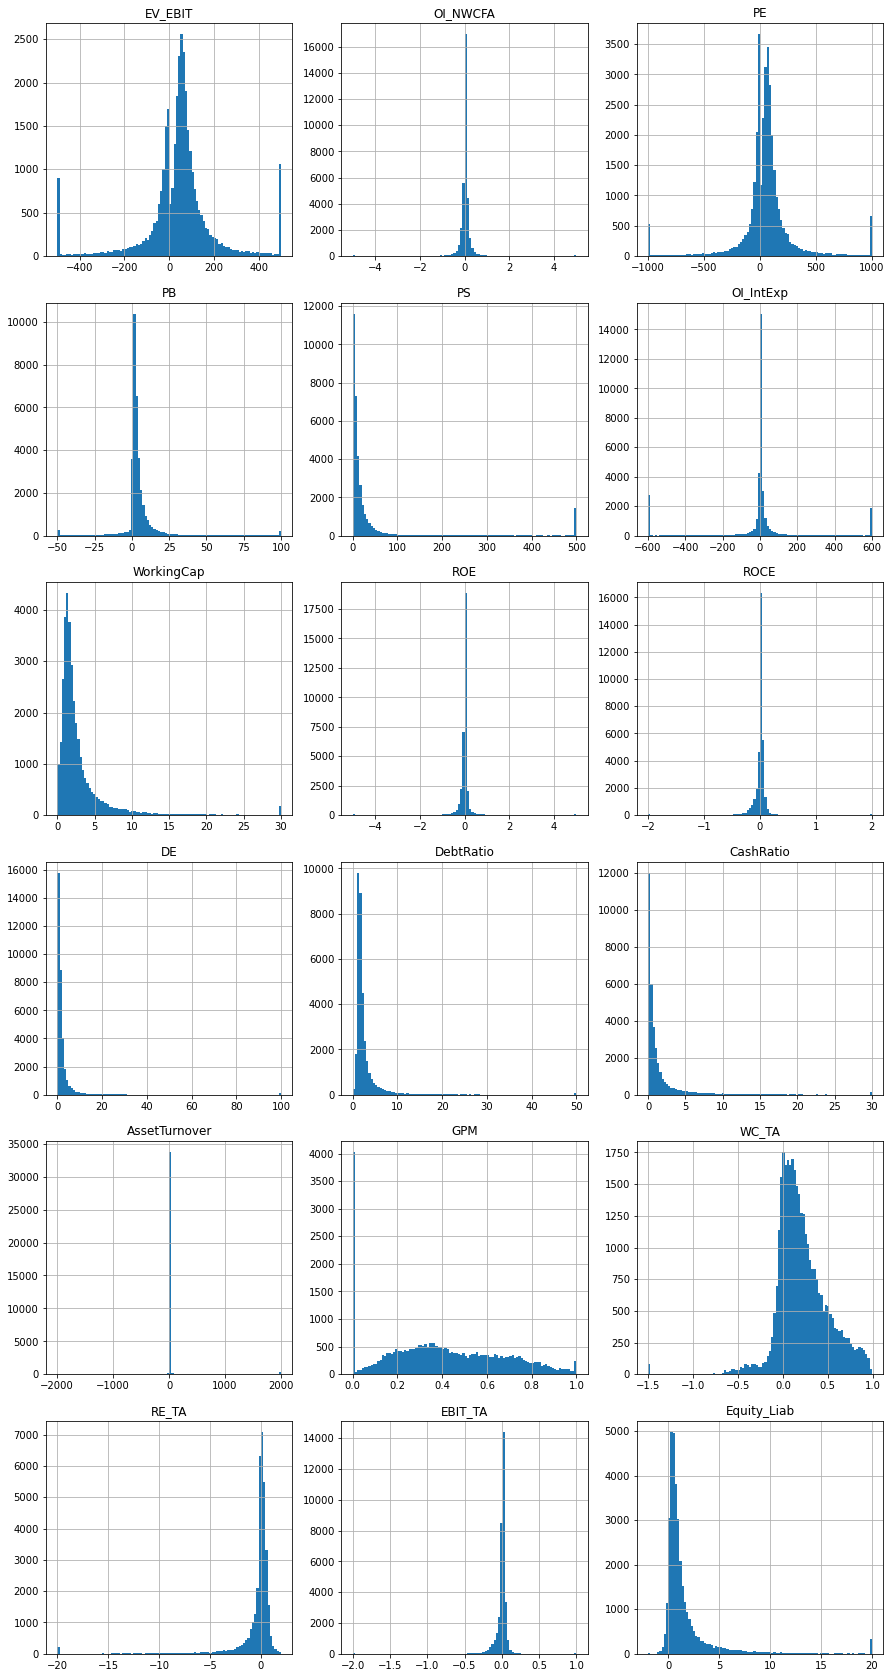

time: 3.94 s (started: 2022-10-05 18:37:14 +08:00)


In [17]:
# Make a plot of the distributions.
cols, rows = 3, 6
plt.figure(figsize=(5*cols, 5*rows))

for i in range(0, cols*rows):
    if i<len(X.keys()):
        plt.subplot(rows, cols, i+1)
        k=X.keys()[i]
        X[k].hist(bins=100)
        plt.title(k);

In [18]:
# save to csv
X.to_csv("./data/03_PerformancePct.csv")
y.to_csv("./data/03_FundamentalRatios.csv")

time: 703 ms (started: 2022-10-05 18:37:18 +08:00)


Data does not seem to have good distribution. Try using PowerTransformer to get good distributions and to make data more Gaussian-like.

This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

In [19]:
from sklearn.preprocessing import PowerTransformer

time: 94 ms (started: 2022-10-05 18:37:18 +08:00)


In [20]:
# There are a total of 18 features
X.columns

Index(['EV_EBIT', 'OI_NWCFA', 'PE', 'PB', 'PS', 'OI_IntExp', 'WorkingCap',
       'ROE', 'ROCE', 'DE', 'DebtRatio', 'CashRatio', 'AssetTurnover', 'GPM',
       'WC_TA', 'RE_TA', 'EBIT_TA', 'Equity_Liab'],
      dtype='object')

time: 0 ns (started: 2022-10-05 18:37:18 +08:00)


In [21]:
# Instantiate the PowerTransformer, then fit and transform the data
transformer = PowerTransformer()
X_transformed = pd.DataFrame(transformer.fit_transform(X), columns=X.columns)

# Define function to plot X features
def plotFeatures(feature_index, df):
    feature = df.columns[feature_index]
    plt.hist(df[feature], density=True, bins=30)
    plt.grid()
    plt.xlabel(feature)
    plt.ylabel('Probability')

time: 437 ms (started: 2022-10-05 18:37:19 +08:00)


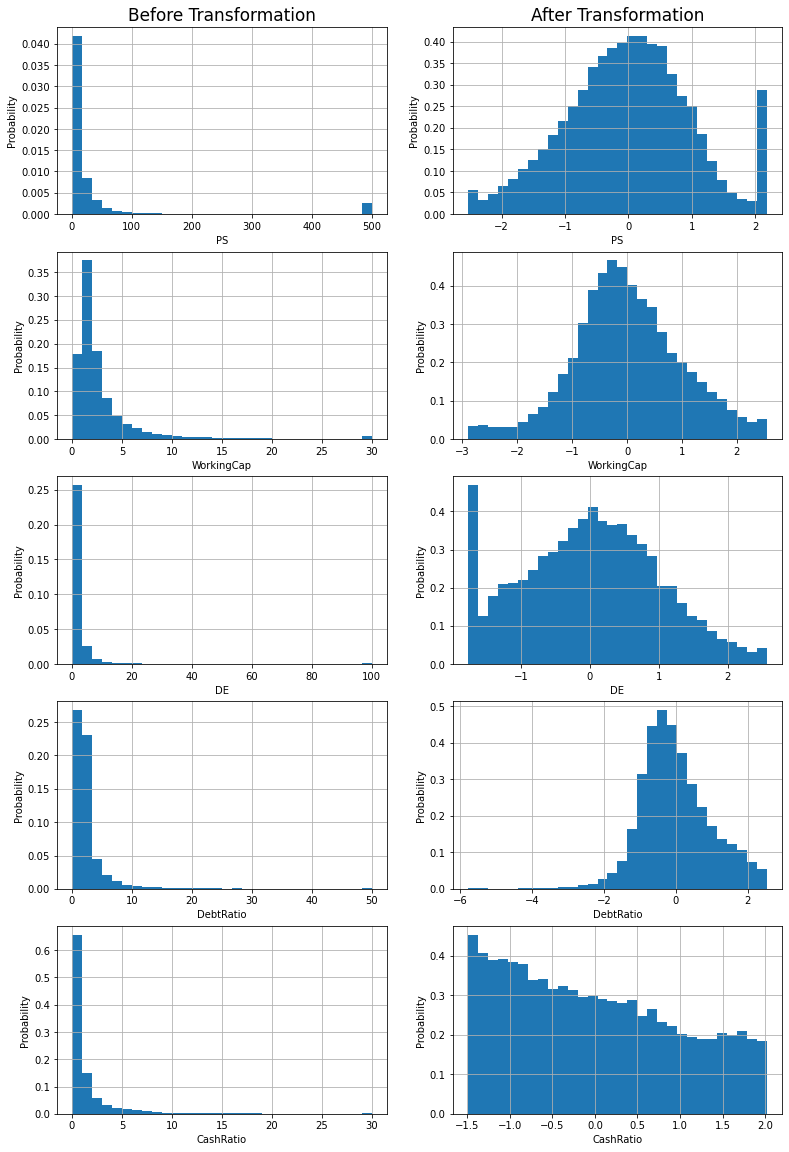

time: 2.67 s (started: 2022-10-05 18:37:19 +08:00)


In [22]:
# Visualise some features before and after transformation
plot_list = [4,6,9,10,11] # using indexing

plt.figure(figsize=(13,20))
j=1
for i in plot_list:
    
    # create subplots with number of rows, columns and index (starts with 1)
    plt.subplot(len(plot_list), 2, 2*j-1)
    plotFeatures(i, X)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    
    plt.subplot(len(plot_list),2,2*j)
    plotFeatures(i, X_transformed)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('TransformedFeatures.png', dpi=300)

In [23]:
pickle.dump(X, open('./data/fundamentals3.pkl', 'wb'))
pickle.dump(y, open('./data/performance3.pkl', 'wb'))

time: 0 ns (started: 2022-10-05 18:37:22 +08:00)


In [24]:
# save the final file to csv
X.to_csv("./data/Final_StocksFundamentals.csv")
y.to_csv("./data/Final_StockPerformanceAnnual.csv")

time: 656 ms (started: 2022-10-05 18:37:22 +08:00)


In [25]:
X.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422


time: 15 ms (started: 2022-10-05 18:37:22 +08:00)


In [26]:
y.head()

,Ticker,Returns
0,A,0.563351
1,A,0.535595
2,A,0.198018
3,A,0.076426
4,A,-0.050044


time: 0 ns (started: 2022-10-05 18:37:22 +08:00)
